# Ames Housing Prices

## Purpose of the Analysis:

### Find out which Variables Strongly Affect the Housing Prices

The objective of the project is to use the Ames Housing dataset to determine which independent variables are the most important to the housing prices in Ames, Iowa. The parts of the notebook is split into the EDA, Feature Engineering, and Modeling where regression will be conducted. Three types of regression will be conducted (Ordinary Least Square, Ridge Regression, and Lasso Regression). The root means squared error will be used to determine the training error, cross validation error, and test error. The absolute value of the highest coefficients corresponds to the most important features of the housing prices.

The file codebook.txt in the repository gives a description of what each independent variable is in the data.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')
training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

full_data.shape

(2000, 82)

## EDA

First, we will see the amount of missing data in each column and drop those that have too many to the point where it isn't meaningful to analyze them.

In [7]:
#Remove features with lots of NA
nanmean=training_data.isna().mean()*100
nan=nanmean[nanmean>25].sort_values(ascending=False)
print(nan)

training_data.drop(columns=nan.index,inplace=True)

Pool_QC         99.5000
Misc_Feature    96.0000
Alley           93.9375
Fence           80.6250
Fireplace_Qu    48.6875
dtype: float64


C:\Users\bench\Anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The joint plot was made to see if there are outliers. There are outliers present when the sales price is large and where the living area is greater than 500 sq. ft.

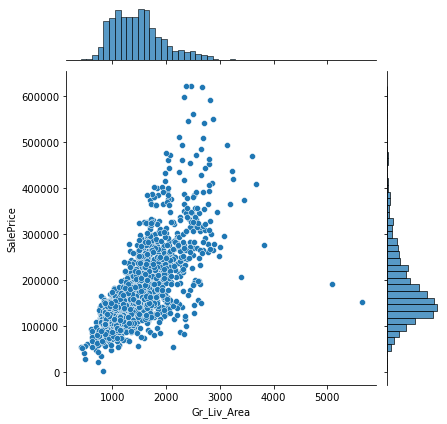

In [8]:
#outliers for living area vs price

training_data.columns.values

sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
);

Check how much of the data is within 2 SD of the average.

In [9]:
#2 SD for sales price

salepricemean=np.mean(training_data['SalePrice'])
salepricestd=np.std(training_data['SalePrice'])

print('Mean Sales Price: ', salepricemean)
print('STD Sales Price: ', salepricestd)

salepricerange=(salepricemean-(2*salepricestd),salepricemean+(2*salepricestd))
salepricerange

Mean Sales Price:  181503.679375
STD Sales Price:  81770.00223512761


(17963.67490474478, 345043.68384525523)

Upon looking at the data more, outliers exists when the Gr_Liv_Area is greater than 5,000 because they were partial sales. Therefore, it is in our interest to remove the outliers so our regression can fit more accurately.

Text(0, 0.5, 'Frequency')

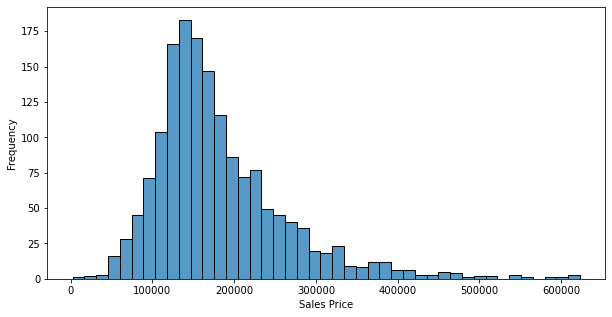

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='SalePrice')
plt.xlabel("Sales Price")
plt.ylabel("Frequency")

In [11]:
#check outliers

training_data.loc[training_data['Gr_Liv_Area']>4000,['Gr_Liv_Area','SalePrice']]

,Gr_Liv_Area,SalePrice
1471,5095,190950
1014,5642,152200


In [12]:
def remove_outliers(data, variable, upper):
    return data.loc[(data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Gr_Liv_Area', 4000)

The type of data in each variable will help determine how we will manipulate each variable.

In [13]:
training_data.dtypes.value_counts()

object     38
int64      30
float64     9
dtype: int64

The distribution of neighborhoods in the data might give us something insightful. We see that most of the houses reside in the Ames area, which is expected.

<AxesSubplot:xlabel='Neighborhood'>

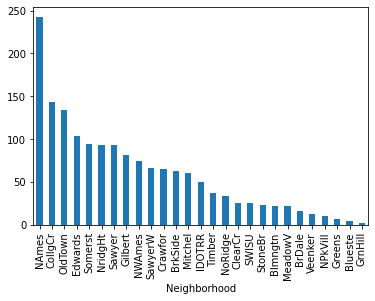

In [14]:
training_data.groupby('Neighborhood').size().sort_values(ascending=False).plot(kind='bar')

The correlation between the Sales Price and the numerical variables will help determine which variables to choose in our linear regression. One thing to keep in mind is colinearity within the data. This will be addressed later in the notebook.

Text(0, 0.5, 'Feature')

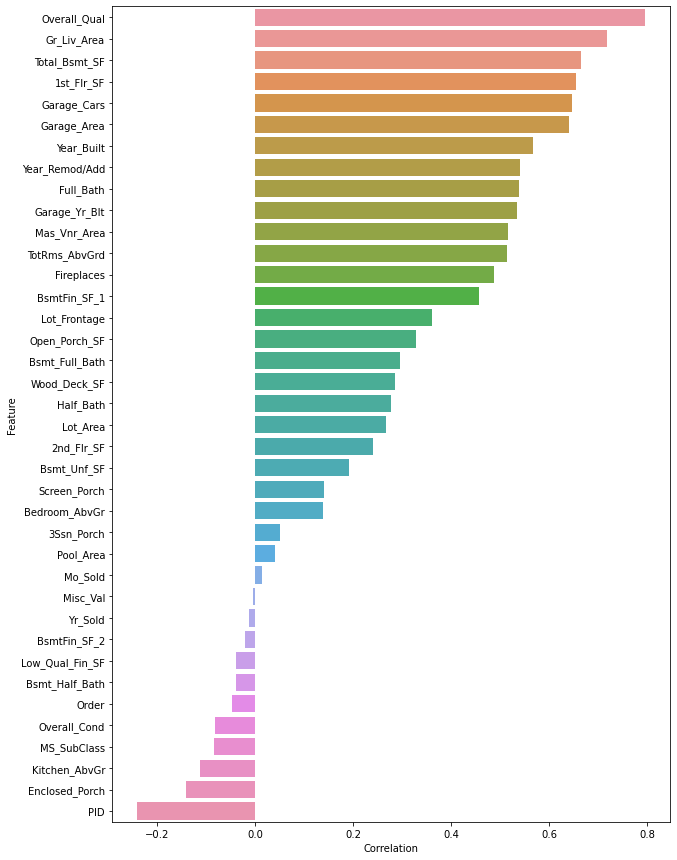

In [15]:
num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()

sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)
ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(y=sale_price_corr.keys(),x=sale_price_corr.values)
plt.xlabel("Correlation")
plt.ylabel("Feature")

There is some interesting remarks from the barplot. Intuitively, one can expect that if there are more bedrooms, the sale price will be higher. However, from creating a scatter plot, there doesn't seem to be a clear correlation. 

<AxesSubplot:xlabel='Bedroom_AbvGr', ylabel='SalePrice'>

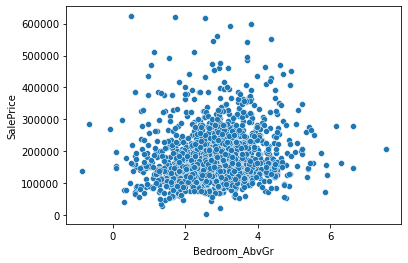

In [16]:
noise = np.random.normal(0,0.5,training_data.shape[0])
training_data_2=training_data
training_data_2['Bedroom_AbvGr']=training_data_2['Bedroom_AbvGr']+noise
sns.scatterplot(data=training_data_2,x='Bedroom_AbvGr',y='SalePrice')

The overall quality of the house (rated 1-10) seemed to have the highest correlation. Let's see how the scatter plot looks like.

<AxesSubplot:xlabel='Overall_Qual', ylabel='SalePrice'>

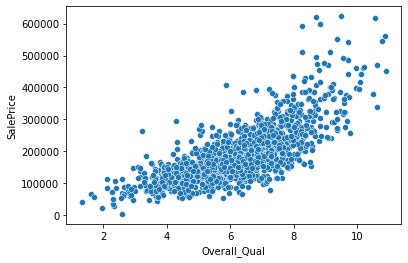

In [17]:
training_data_2=training_data
training_data_2['Overall_Qual']=training_data_2['Overall_Qual']+noise
sns.scatterplot(data=training_data_2,x='Overall_Qual',y='SalePrice')

From the plot, we can conclude that a lot of houses around that area were newly built. This might cause the data to be slightly skewed towards having newer, higher-quality houses compared to houses that were built in the 1900s. However, this makes sense because the older houses are likely outdated and replaced by modern, updated houses over time. There can also be population growth in the area, which in turn causes a lot of houses to be built in the 2000s.

Text(0, 0.5, 'Frequency')

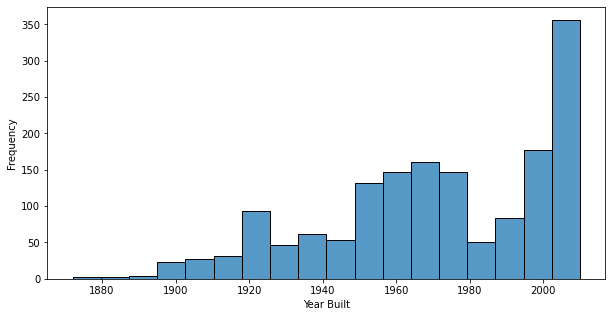

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='Year_Built')
plt.xlabel('Year Built')
plt.ylabel("Frequency")

## Feature Engineering

We will now explore variables where feature engineering is required.

Given the number of variables that show the quantity of bathrooms, we can combine it into a variable with the total number of bathrooms as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

*Idea from Data 200 Notebook

In [19]:
def add_total_bathrooms(data):
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms']=with_bathrooms[bath_vars].fillna(0)@weights
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

A scatter plot was created to show there was a positive correlation between the number of total bathrooms and the sale price.

<AxesSubplot:xlabel='TotalBathrooms', ylabel='SalePrice'>

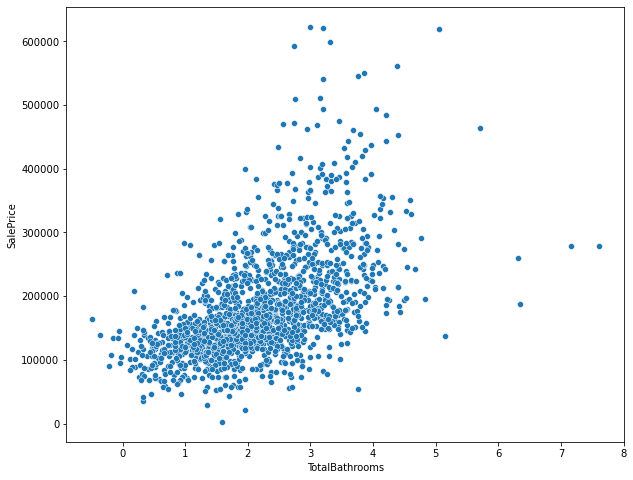

In [20]:
training_data_2=training_data
training_data_2['TotalBathrooms']=training_data_2['TotalBathrooms']+noise
plt.figure(figsize=(10,8))
sns.scatterplot(data=training_data_2,x='TotalBathrooms',y='SalePrice')

The feature was created because it would better capture the total amount of useable area within the house, which would intuitively make the house more valuable. There is a strong correlation between the basement square feet and the living area above ground to the sales price, so combining the variables might increase the correlation.

In [21]:
def add_total_SF(data):
    totalSFdf = data.copy()
    totalSFdf['Total_SF'] = totalSFdf['Total_Bsmt_SF'] + totalSFdf['Gr_Liv_Area']
    return totalSFdf

training_data = add_total_SF(training_data)

Text(0, 0.5, 'Frequency')

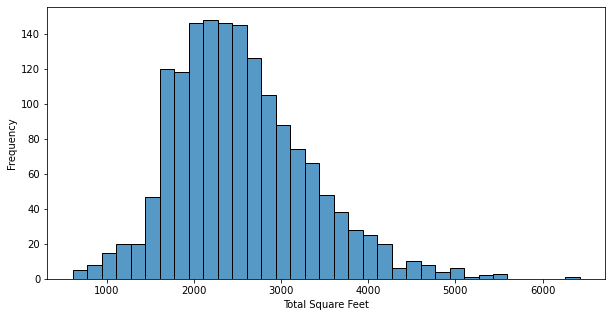

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(training_data, x='Total_SF')
plt.xlabel('Total Square Feet')
plt.ylabel("Frequency")

Next, houses that are in rich neighborhoods are likely to be more expensive. From grouping the data by the neighborhoods, there are three distinct neighborhoods that have the largest sales price, followed by a small dropoff. 

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000., 400000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

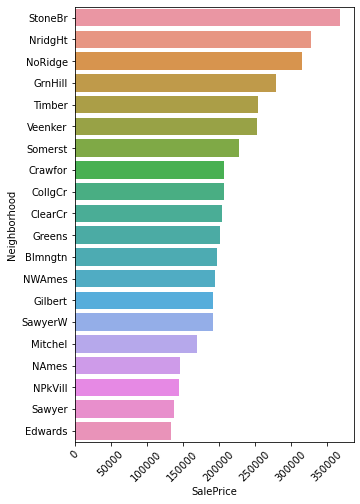

In [23]:
def find_rich_neighborhoods(data, n=3, metric=np.mean):
    neighborhoods = data.groupby('Neighborhood').agg(metric).sort_values('SalePrice',ascending=False).iloc[0:n].index.tolist()
    return neighborhoods

richhoods=training_data.groupby('Neighborhood').agg(np.mean).sort_values('SalePrice',ascending=False).iloc[0:20]
plt.subplots(figsize=(5,8))
sns.barplot(y=richhoods.index,x=richhoods.SalePrice)
plt.xticks(rotation=45)

The following will add a one hot encoding feature of the four wealthiest neighborhood to the dataset.

In [24]:
def add_in_rich_neighborhood(data, neighborhoods):
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype(int)
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 4, np.mean)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

One hot encoding will be used for categorical variables. The following is a function that will one hot encode variables.

In [25]:
categorical = (training_data.dtypes == "object")
categorical_list = list(categorical[categorical].index)
print(categorical_list)

def encode(data):
    categorical = (data.dtypes == "object")
    categorical_list = list(categorical[categorical].index)
    for i in categorical_list:
        encode=preprocessing.LabelEncoder()
        data[i]=encode.fit_transform(data[i])
    return data
training_data=encode(training_data)

['MS_Zoning', 'Street', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style', 'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional', 'Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Sale_Type', 'Sale_Condition']


To lower the error of our fit, it is best to optimize the amount of variables we add to our regression model. The following will test the bounds of our cross-validation error by adding variables to our model before the cross-validation error increases (i.e. bias-variance tradeoff).

Before creating our model, the most important features in determining housing prices will be investigated using random forest, gradient boosting, and correlation. After that, we will do an initial fit to our model and gradually add more features and determine the RMSE. This will help us see the optimal number of features to add to prevent overfitting.

From the plot, it is noted that the importance of features resembles an exponential decay curve when both using random forest and gradient boosting. This might suggest that we will see a sharp decrease in the RMSE when adding the first few features, and then the RMSE will slowly decrease as we add the less important features.

In the plot, it is noted that there is a sharp decrease in the RMSE as we kept adding features to a total of ten. After that, there was a smaller decrease in the RMSE each time that we added features. It was decided to set the cutoff at 20 features for gradient boosting to achieve the optimal performance of our model.

[53009.94364884375, 39532.35438786025, 36939.85052579401, 36774.18864889889, 35150.202204982765, 33302.243102204986, 33301.26968277674, 32865.58905746387, 32333.942762955052, 32347.422874696746]


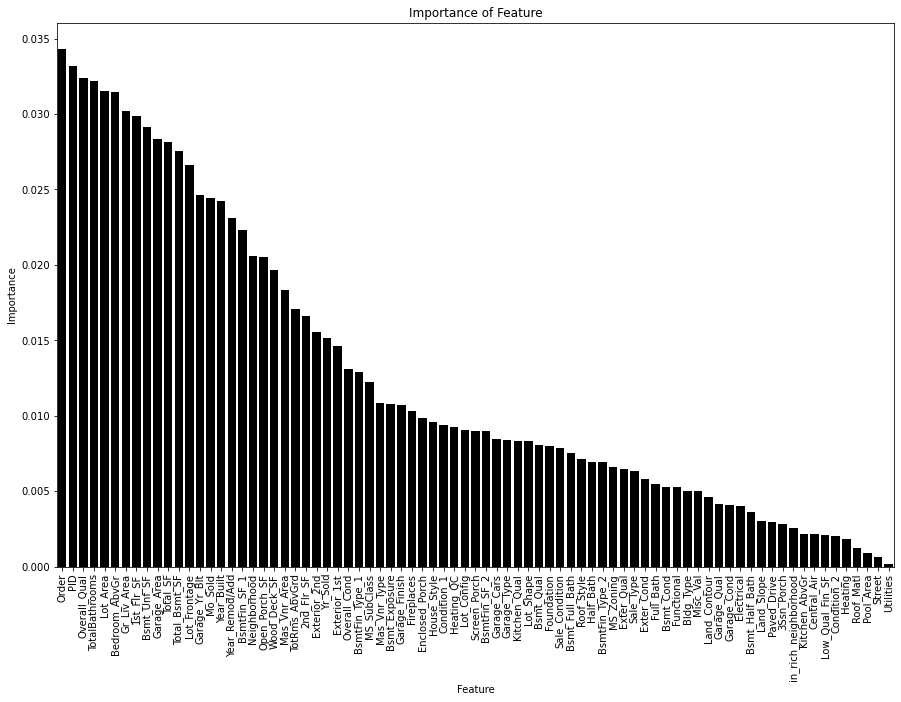

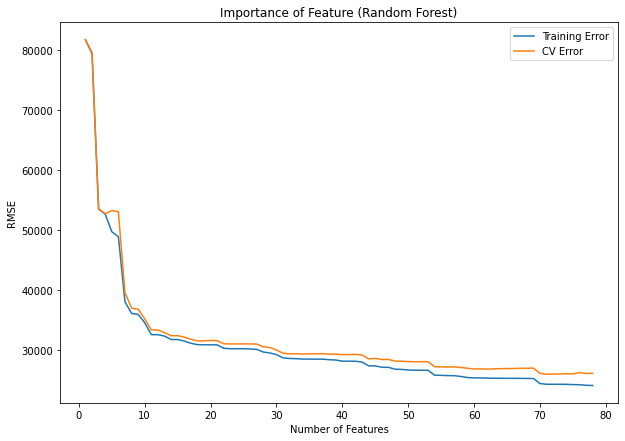

In [26]:
#Feature Importance (RF)

X=training_data.drop(columns=['SalePrice'])
Y=training_data['SalePrice']

for i in range(len(num_cols)-1):
    meanvar=np.nanmean(X[num_cols[i]])
    X[num_cols[i]].fillna(meanvar,inplace=True)

X=X.fillna(method="pad")

clf = ensemble.RandomForestClassifier()
clf = clf.fit(X, Y)
features = X.columns
importances = clf.feature_importances_
idxrf = np.argsort(importances)[::-1]

plt.figure(figsize=(15,10))
sns.barplot(x=np.arange(len(idxrf)),y=importances[idxrf], color = 'black')
plt.xticks(range(len(idxrf)), [features[i] for i in idxrf], rotation='vertical')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Feature')

#number of features based on trees

features=79
rmse = np.zeros(features-1)

# loop over the Ks

train_error_vs_N = []
cv_error_vs_N = []

for i in range(1,features):
    trainingx=X.iloc[:,idxrf[0:i]]
    trainingy=Y

    linear_model=lm.LinearRegression()
    
    cv_results = cross_validate(linear_model, trainingx, trainingy, 
                                cv=5,scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(np.arange(1,features), train_error_vs_N)
sns.lineplot(np.arange(1,features), cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");
plt.title('Importance of Feature (Random Forest)')

print(cv_error_vs_N[5:15])

numfeaturesrf=20

      Iter       Train Loss   Remaining Time 
         1           0.6034           11.14m
         2           0.8160           11.67m
         3           0.7462           11.53m
         4           0.7424           11.22m
         5           0.7395           10.82m
         6           0.7373           10.38m
         7           0.7356            9.94m
         8           0.7342            9.47m
         9           0.7330            8.96m
        10           0.7321            8.43m
        11           0.7314            7.90m
        12           0.7308            7.34m
        13           0.7303            6.78m
        14           0.7299            6.22m
        15           0.7296            5.67m
        16           0.7293            5.12m
        17           0.7291            4.56m
        18           0.7289            4.00m
        19           0.7288            3.43m
        20           0.7286            2.87m
        21           0.7285            2.30m
        2

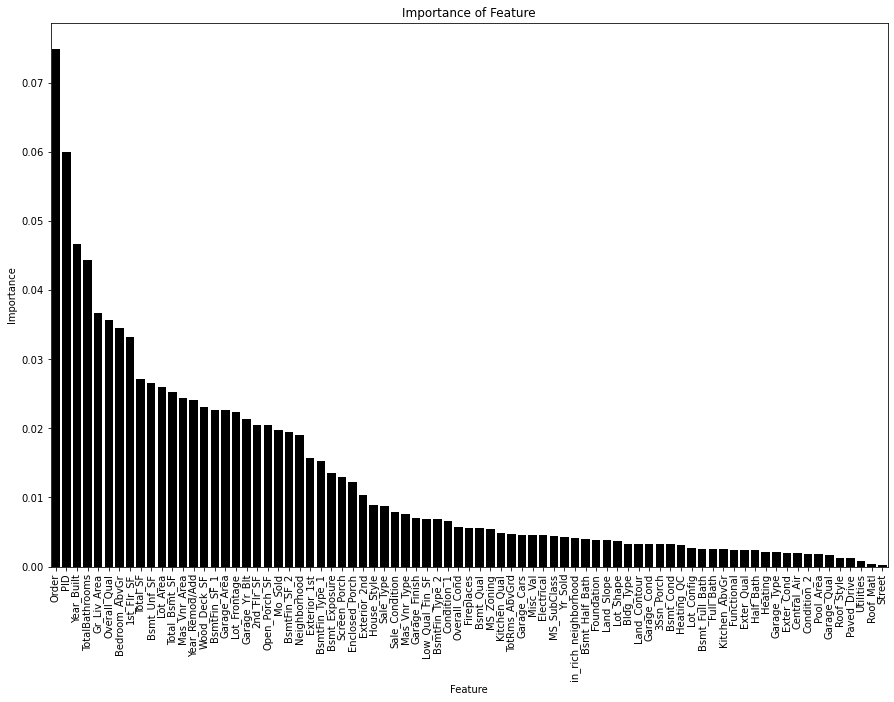

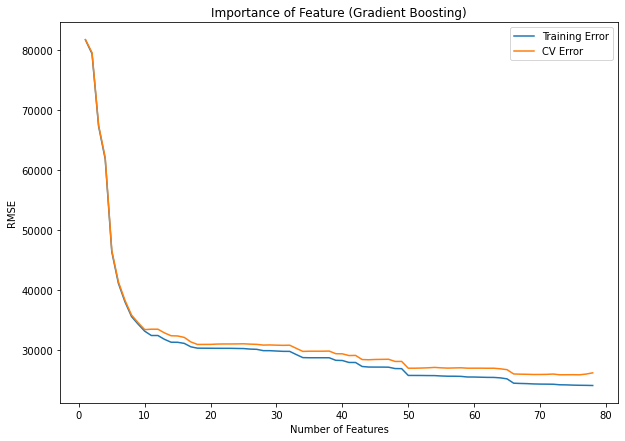

In [27]:
#Feature Importance (Gradient Boosting)

clf = ensemble.GradientBoostingClassifier(n_estimators=25,verbose=3)
clf = clf.fit(X, Y)
features = X.columns
importances = clf.feature_importances_
idxgb = np.argsort(importances)[::-1]

plt.figure(figsize=(15,10))
sns.barplot(x=np.arange(len(idxgb)),y=importances[idxgb], color = 'black')
plt.xticks(range(len(idxgb)), [features[i] for i in idxgb], rotation='vertical')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Feature')

#number of features based on gb

features=79
rmse = np.zeros(features-1)

# loop over the Ks

train_error_vs_N = []
cv_error_vs_N = []

for i in range(1,features):
    trainingx=X.iloc[:,idxgb[0:i]]
    trainingy=Y

    linear_model=lm.LinearRegression()
    
    cv_results = cross_validate(linear_model, trainingx, trainingy, 
                                cv=5,scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(np.arange(1,features), train_error_vs_N)
sns.lineplot(np.arange(1,features), cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");
plt.title('Importance of Feature (Gradient Boosting)')

print(cv_error_vs_N[10:20])

numfeaturesgb=20

The correlation will only factor in numerical variables. The RMSE is plotted for each addition of a variable.

The plot illustrates that the RMSE decreases up until the 15th feature. After that, the RMSE flattens out and then slightly decreases further. Therefore, choosing 10-15 variables is optimal to lower the RMSE and to prevent a low bias and high variance.

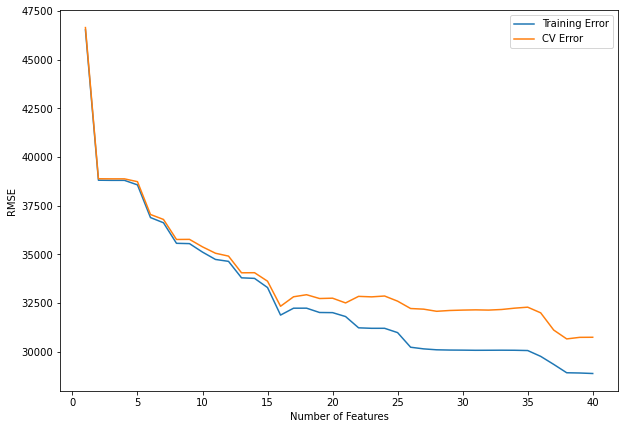

In [28]:
#number of features based on corr

train_error_vs_N = []
cv_error_vs_N = []
linear_model=lm.LinearRegression()

num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()
sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)

range_of_num_features = range(1, sale_price_corr.shape[0] + 1)

for N in range_of_num_features:
    sale_price_corr_first_N_features = sale_price_corr.iloc[:N]
    saleprice=training_data['SalePrice'].drop(training_data.index
                                              [training_data[sale_price_corr.iloc[:N].index]
                                               .isnull().any(1)])
    indepVar=training_data[sale_price_corr_first_N_features.index].dropna()
    
    scaler=preprocessing.StandardScaler()
    indepVar = pd.DataFrame(scaler.fit_transform(indepVar),columns = indepVar.columns)
    
    cv_results = cross_validate(linear_model, indepVar, saleprice, cv=4,
                                scoring=('r2', 'neg_root_mean_squared_error'),
                                return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)

plt.figure(figsize=(10,7))
sns.lineplot(range_of_num_features, train_error_vs_N)
sns.lineplot(range_of_num_features, cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");

Further illustration shows exactly where the dip occurs before the RMSE rises again. The valley seems to occur on the 14th variable.

In [29]:
print(cv_error_vs_N[10:20])

#numfeaturescorr=16
numfeaturescorr=20

[35058.80629617566, 34911.66043677561, 34054.58018090302, 34059.740391851505, 33623.07189169283, 32336.025333691177, 32823.33987547279, 32928.496018333455, 32733.568498117747, 32750.69986905998]


From the 14 variables, it is important to take out variables that are dependent on each other. A heat map with the correlation between the variables were made. 

For example, the amount of cars you can fit into a garage is highly correlated to the garage area, which makes sense. Therefore, we need to delete one of the variables.

<AxesSubplot:>

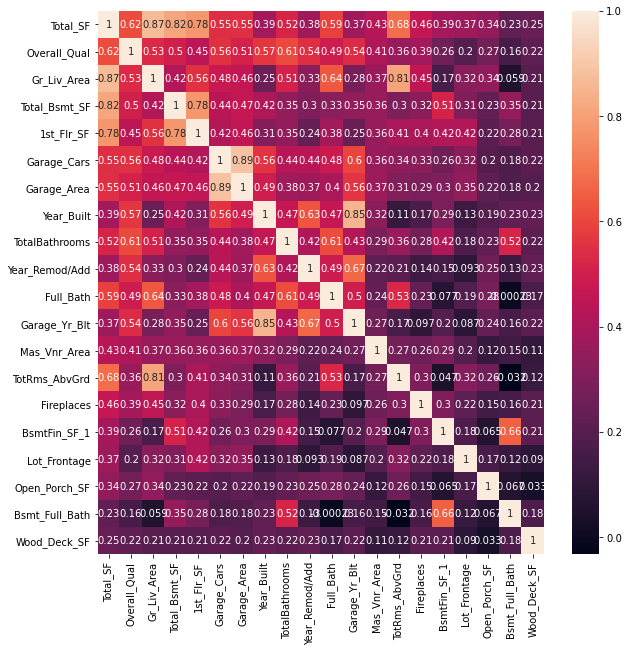

In [30]:
#multicorr test

features=sale_price_corr.iloc[:numfeaturescorr]

plt.figure(figsize=(10,10))
sns.heatmap(training_data[features.index].corr(),annot=True)

From observing the heat map, there were 5 variables that I decided to take out to minimize multicollinearity.

In [31]:
colinear=['TotRms_AbvGrd','Garage_Area','Year_Remod/Add','Full_Bath','Garage_Yr_Blt']

idxcorr=[]

for i in range(len(features.index.to_list())):
    idxcorr.append(training_data.columns.get_loc(sale_price_corr.index.to_list()[i]))
idxcorr.insert(0,76)
idxcorr=np.array(idxcorr)

## Modeling

We will define our pipeline to create the dataframe that will be passed into the regression models.

In [32]:
def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data.iloc[:, columns]

def process_data_fm(data, overall_features):
    data = remove_outliers(data, 'Gr_Liv_Area', 4000)
    data = add_total_bathrooms(data)
    
    # Transform Data, Select Features
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, overall_features)
        
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    
    numf=X.dtypes[(X.dtypes == 'int64') | (X.dtypes == 'float64')].index
    scaler=preprocessing.StandardScaler()
    X.loc[:,numf] = scaler.fit_transform(X.loc[:,numf])
    X = encode(X)
    
    y = data.loc[:, 'SalePrice']
    X=X.fillna(method="pad")
    X=X.fillna(method="bfill")
    return X, y

### Ordinary Least Square

The first type of regression that will be conducted is the ordinary least square. The function defined will fit the data to the model, output the actual vs predicted values, and output the residual plot. 

In [33]:
def OLSrun(X_train_n, y_train, X_test_n, y_test):  

    final_model = lm.LinearRegression()
    final_model.fit(X_train_n, y_train)
    y_predicted_train = final_model.predict(X_train_n)
    y_predicted_test = final_model.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_predicted_train, y_train,squared=False)
    test_rmse = metrics.mean_squared_error(y_predicted_test, y_test,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    #Line Plot
    plt.figure(figsize=(10,7))
    ax=sns.scatterplot(y_predicted_train,y_train,label="Training")
    sns.scatterplot(y_predicted_test,y_test,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_predicted_train,y_train,label="Training")
    sns.residplot(y_predicted_test,y_test,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()

### Ridge Regression

The second type of regression that will be implemented is the ridge regression. Since the regularization parameter depends on the coefficents of our regression, the data has to be standardized to prevent one feature from being overrepresented.

In [34]:
def ridgerun(X_train_n, y_train_n, X_test_n, y_test_n):
    
    param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
    final_ridge = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
    final_ridge.fit(X_train_n, y_train_n)
    alpha = final_ridge.best_params_['alpha']
    print('Initial Best Alpha', alpha)
    
    param_gridimp = {'alpha': list(np.linspace(alpha-(alpha*0.2),alpha+(alpha*0.2),200))}
    final_ridgeimp = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
    final_ridgeimp.fit(X_train_n, y_train_n)
    alphaimp = final_ridgeimp.best_params_['alpha']
    print('Improved Best Alpha', round(alphaimp,2))
    
    
    y_ridge_train = final_ridgeimp.predict(X_train_n)
    y_ridge_test = final_ridgeimp.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_ridge_train, y_train_n,squared=False)
    test_rmse = metrics.mean_squared_error(y_ridge_test, y_test_n,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    
    #Line Plot
    plt.figure(figsize=(10,7))
    
    ax=sns.scatterplot(y_ridge_train,y_train_n,label="Training")
    sns.scatterplot(y_ridge_test,y_test_n,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_ridge_train,y_train_n,label="Training")
    sns.residplot(y_ridge_test,y_test_n,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()
    
    #Feature Importance
    ridge=final_ridgeimp.best_estimator_
    
    coefs = pd.DataFrame({'coefs':ridge.coef_}, index=X_train_n.columns)
    coefs['coefs_abs'] = np.abs(coefs.coefs)
    
    top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10)
    plt.figure(figsize=(8,10))
    sns.barplot( top_coefs.coefs_abs, top_coefs.index)
    plt.title('Ridge Regression: Top Features')
    plt.xlabel('Absolute Coefficient')
    plt.show()

### Lasso Regression

The third type of regression that will be implemented is the lasso regression. We will use the standardized data for the same reason as the ridge regression.

In [35]:
def lassorun(X_train_n, y_train_n, X_test_n, y_test_n):  

    param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100., 500., 1000.]}
    final_lasso = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
    final_lasso.fit(X_train_n, y_train_n)
    alpha = final_lasso.best_params_['alpha']
    print('Initial Best Alpha', alpha)
    
    param_gridimp = {'alpha': list(np.linspace(alpha-(alpha*0.2),alpha+(alpha*0.2),1000))}
    final_lassoimp = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
    final_lassoimp.fit(X_train_n, y_train_n)
    alphaimp = final_lassoimp.best_params_['alpha']
    print('Improved Best Alpha', round(alphaimp,2))
    
    y_lasso_train = final_lassoimp.predict(X_train_n)
    y_lasso_test = final_lassoimp.predict(X_test_n)
    
    training_rmse = metrics.mean_squared_error(y_lasso_train, y_train_n,squared=False)
    test_rmse = metrics.mean_squared_error(y_lasso_test, y_test_n,squared=False)
    print('Training and Test Error:',round(training_rmse,2),round(test_rmse,2))
    
    
    #Line Plot
    plt.figure(figsize=(10,7))

    ax=sns.scatterplot(y_lasso_train,y_train_n,label="Training")
    sns.scatterplot(y_lasso_test,y_test_n,label="Test",ax=ax)
    sns.lineplot([0,600000],[0,600000],color='red')
    
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('Actual Sales Price')
    ax.legend(loc='upper left')
    plt.show()
    
    
    #Residual Plots
    plt.figure(figsize=(10,7))
    ax=sns.residplot(y_lasso_train,y_train_n,label="Training")
    sns.residplot(y_lasso_test,y_test_n,label="Test",ax=ax)
    plt.xlabel('Predicted Sales Price')
    plt.ylabel('RMSE')
    plt.title('Residual Plot')
    ax.legend(loc='upper left')
    plt.show()
    
    #Feature Importance
    lasso=final_lassoimp.best_estimator_
    
    coefs = pd.DataFrame({'coefs':lasso.coef_}, index=X_train_n.columns)
    coefs['coefs_abs'] = np.abs(coefs.coefs)
    
    top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(10)
    plt.figure(figsize=(8,10))
    sns.barplot( top_coefs.coefs_abs, top_coefs.index)
    plt.title('LASSO Regression: Top Features')
    plt.xlabel('Absolute Coefficient')
    plt.show()

Each of the linear models will be fitted to the data using the function below. The respective feature importance will be added in order (random forest, gradient boosting, correlation).

In [36]:
def runmodels(training_data, test_data, numfeatures, idx):
    training_data = add_total_SF(training_data)
    test_data = add_total_SF(test_data)
    
    X_train, y_train=process_data_fm(training_data,idx[0:numfeatures])
    X_test, y_test=process_data_fm(test_data,idx[0:numfeatures])
    
    X_train_r2 = sm.add_constant(X_train)
    models = sm.OLS(y_train,X_train_r2)
    results = models.fit()
    print(results.summary())
    
    X_train_n = X_train
    X_test_n = X_test
    
    OLSrun(X_train_n, y_train, X_test_n, y_test)
    ridgerun(X_train_n, y_train, X_test_n, y_test)
    lassorun(X_train_n, y_train, X_test_n, y_test)

The data is prepared again to ensure the dataset is clean.

In [37]:
##### Running each model ########

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

#drop too many nan
nan=nanmean[nanmean>25].sort_values(ascending=False)
full_data.drop(columns=nan.index,inplace=True)

training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

training_data.shape

(1600, 77)

Each of the models is ran against the data. We found that the combination of using the important features inferred from gradient boosting because that combination gave the lowest RMSE of 28,981.10. 

From looking at the absolute value fo the coefficients, it is noted that the overall quality of the house and the square feet above ground of the house are the most important features in determining housing prices after conducting ridge regression. Seven of the ten features that also appear in the graph also dealt with the measurement of the square footage, which strongly suggests that the bigger the property, the more that the house will cost.

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     495.2
Date:                Mon, 24 May 2021   Prob (F-statistic):               0.00
Time:                        12:03:28   Log-Likelihood:                -18794.
No. Observations:                1598   AIC:                         3.763e+04
Df Residuals:                    1578   BIC:                         3.774e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.79e+05   1877.803     95.

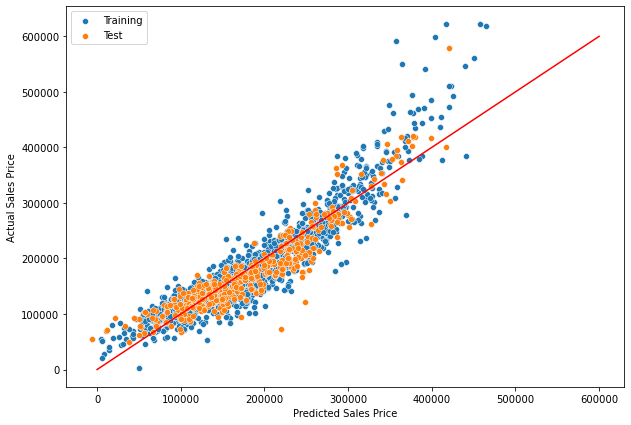

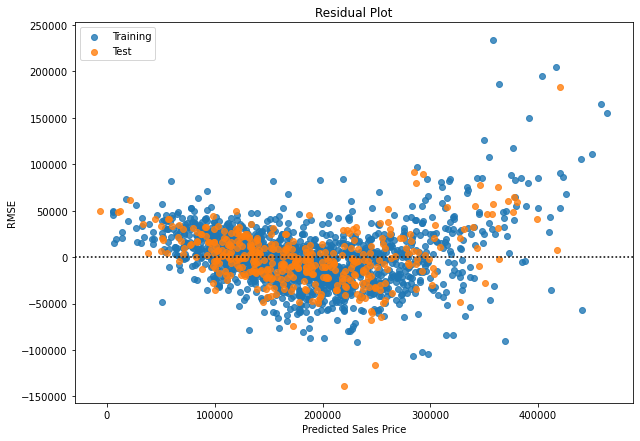

Initial Best Alpha 50.0
Improved Best Alpha 60.0
Training and Test Error: 31055.69 29683.99


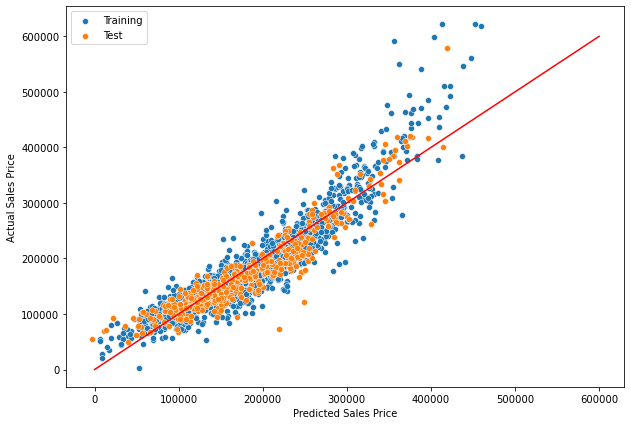

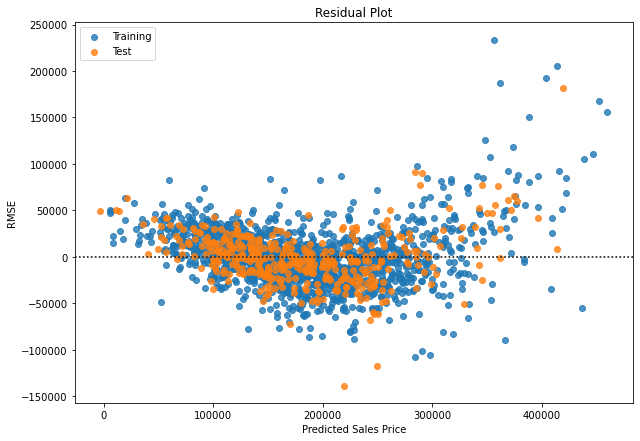

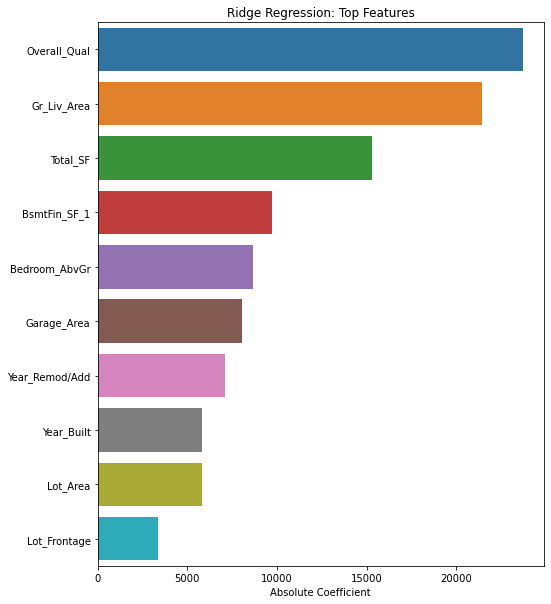

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606955695283.5897, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 645695634987.2781, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601463006588.3011, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Initial Best Alpha 1000.0
Improved Best Alpha 891.29
Training and Test Error: 31105.15 29612.41


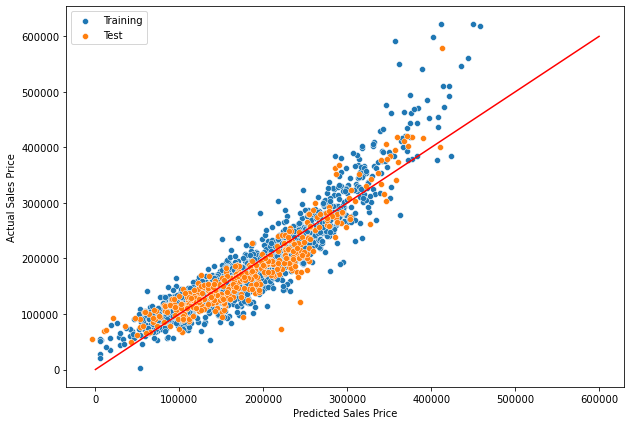

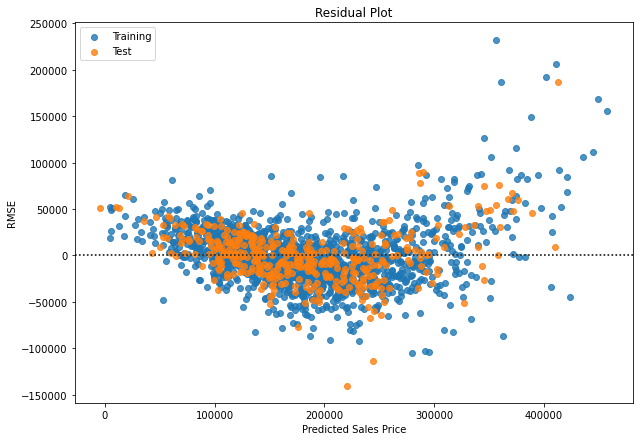

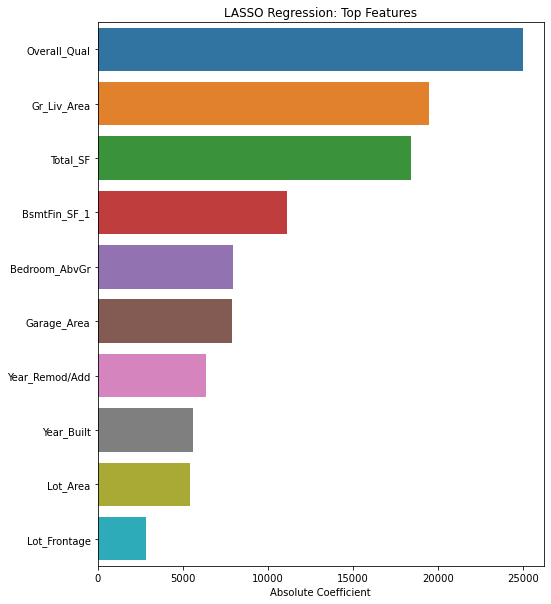

In [38]:
#RF
runmodels(training_data, test_data, numfeaturesrf, idxrf)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     517.3
Date:                Mon, 24 May 2021   Prob (F-statistic):               0.00
Time:                        12:04:02   Log-Likelihood:                -18764.
No. Observations:                1598   AIC:                         3.757e+04
Df Residuals:                    1578   BIC:                         3.768e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.815e+05    766.151    236.

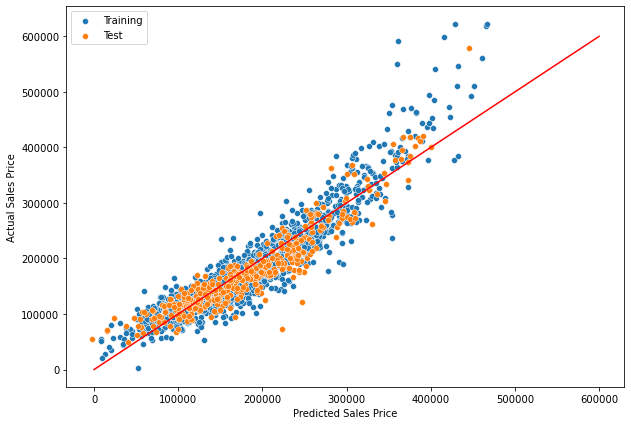

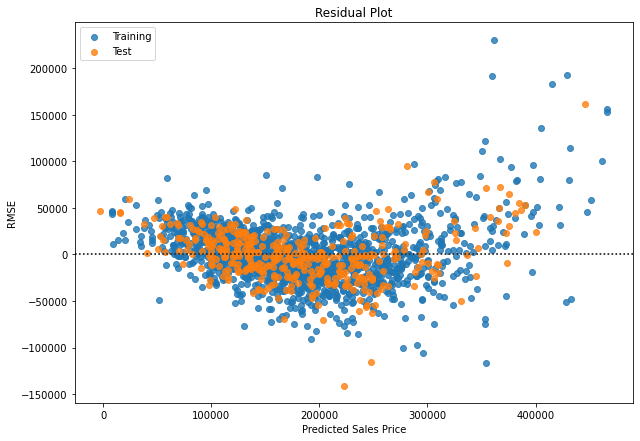

Initial Best Alpha 100.0
Improved Best Alpha 95.48
Training and Test Error: 30495.01 28751.72


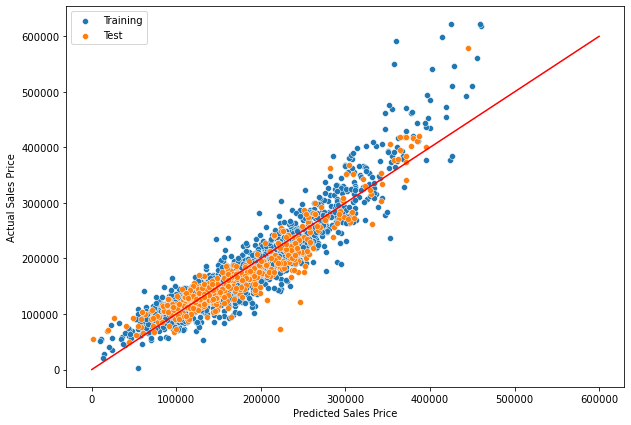

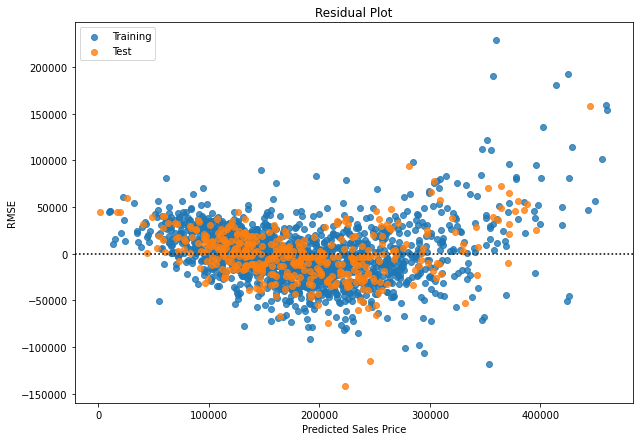

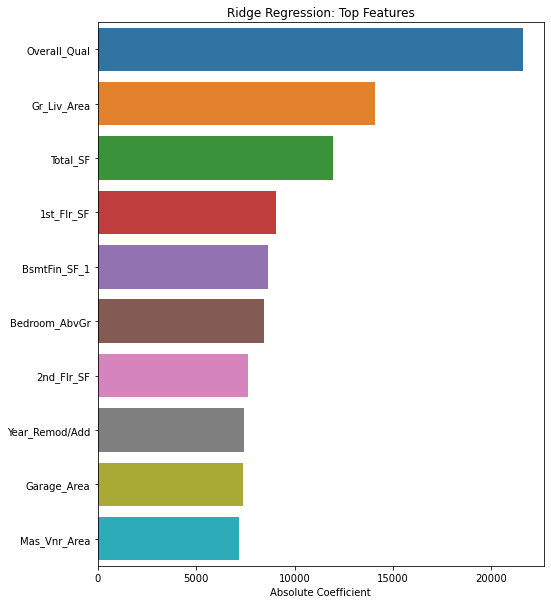

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583123009103.4117, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621155452343.0116, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582767006245.8645, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Initial Best Alpha 1000.0
Improved Best Alpha 850.05
Training and Test Error: 30527.3 28838.96


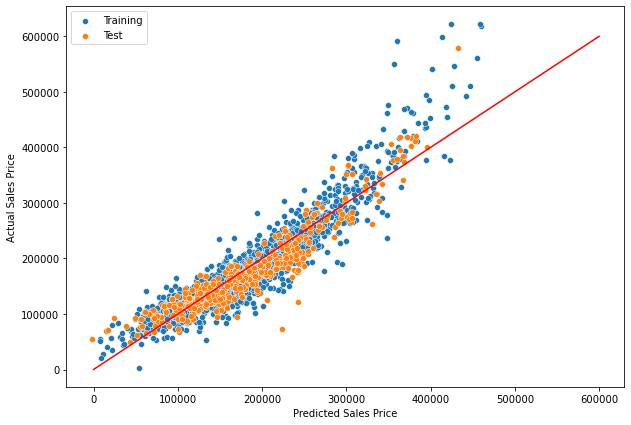

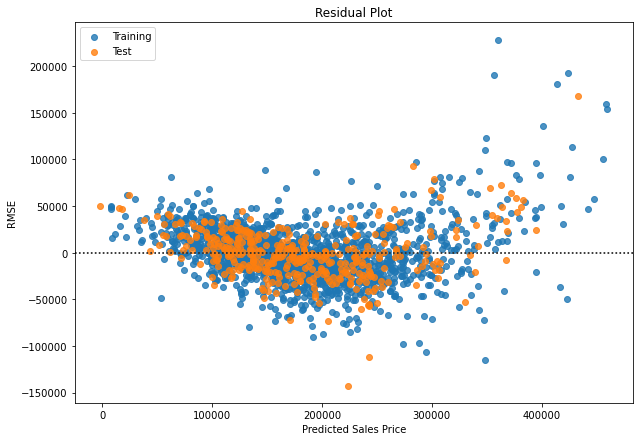

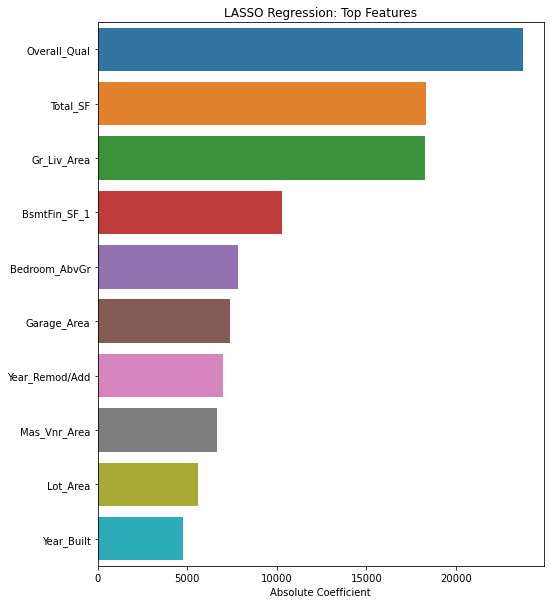

In [39]:
#GB
runmodels(training_data, test_data, numfeaturesgb, idxgb)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     479.8
Date:                Mon, 24 May 2021   Prob (F-statistic):               0.00
Time:                        12:04:36   Log-Likelihood:                -18816.
No. Observations:                1598   AIC:                         3.767e+04
Df Residuals:                    1578   BIC:                         3.778e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.815e+05    791.253    229.

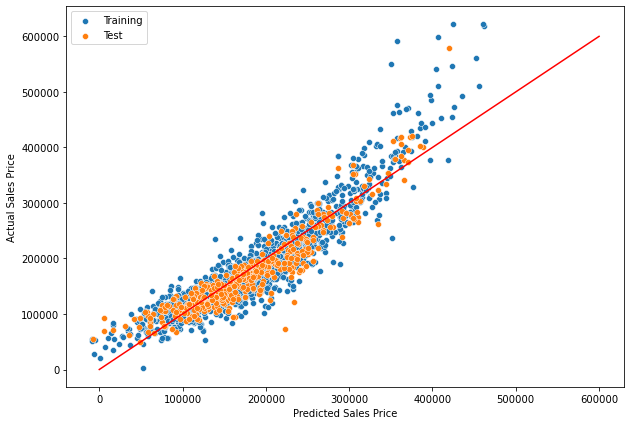

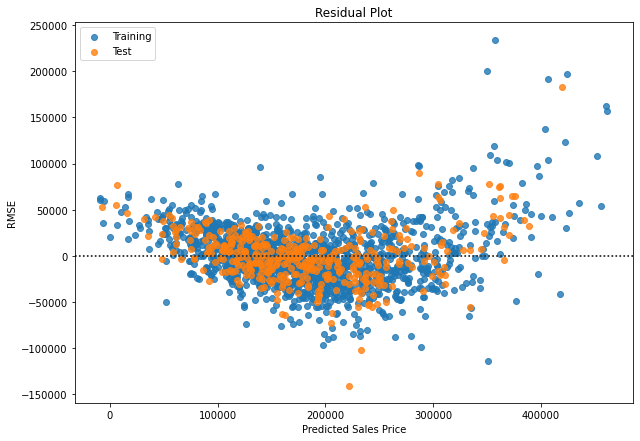

Initial Best Alpha 25.0
Improved Best Alpha 20.0
Training and Test Error: 31435.92 29557.02


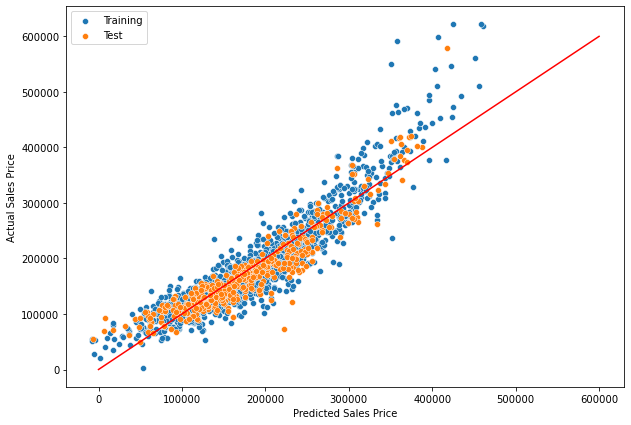

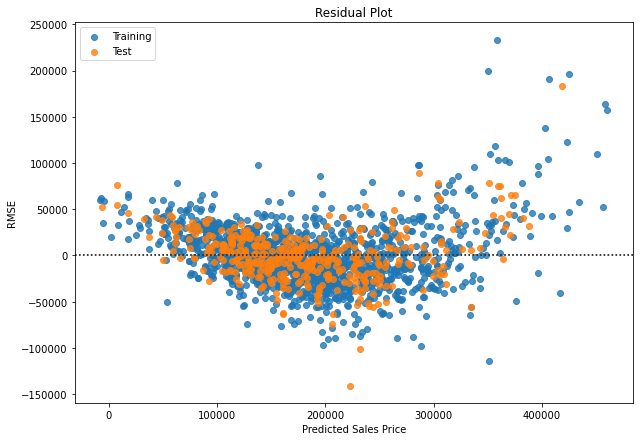

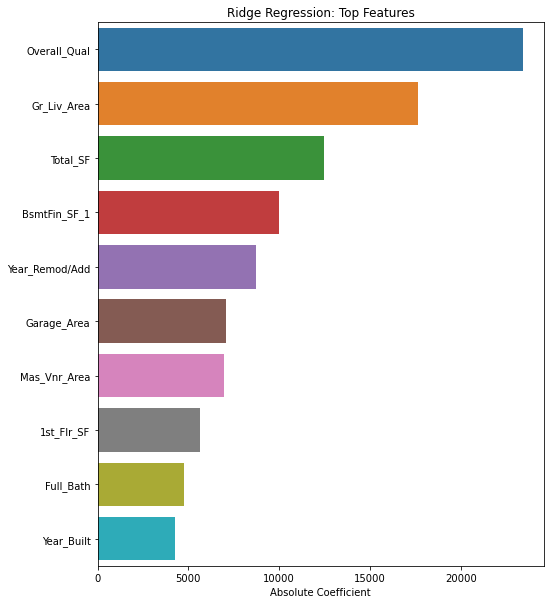

C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 628885642531.0685, tolerance: 831268931.4165038
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 658221207978.7375, tolerance: 895104701.8888875
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623803125843.34, tolerance: 821774594.2901276
  positive)
C:\Users\bench\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Initial Best Alpha 100.0
Improved Best Alpha 119.88
Training and Test Error: 31435.39 29537.54


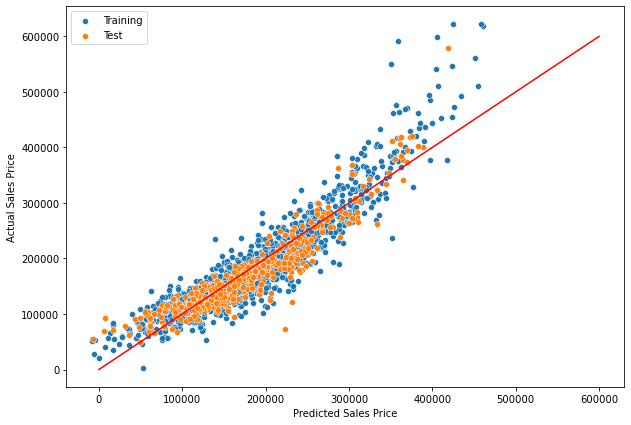

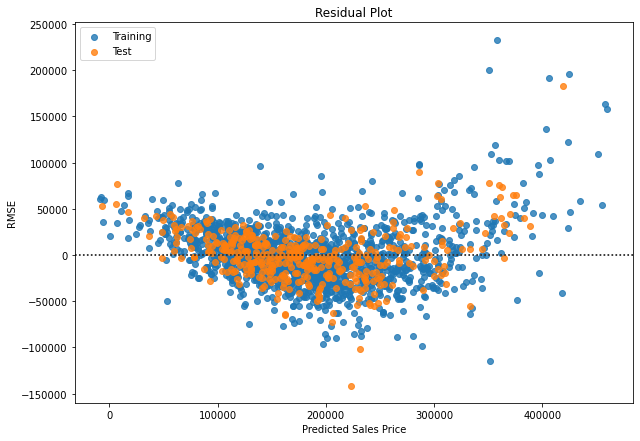

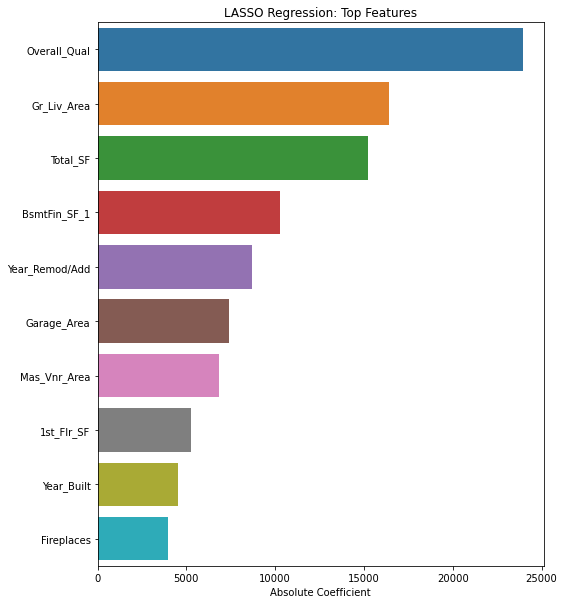

In [40]:
#corr
runmodels(training_data, test_data, numfeaturescorr, idxcorr)

# Conclusion

From our results, we conclude that the square footage of the house and the overall quality of the house are the most important features when determining the sales price of a house. This conclusion was obtained from conducting random forest, gradient boosting, and correlation to the target variable for feature importance. Ordinary least squares, ridge regression, and LASSO regression were conducted to obtain a model. We concluded that the method that obtained the lowest RMSE as our loss was to conduct feature importance using gradient boosting and then ridge regression for model fitting.

For future work, the residual plot could be improved by conducting a log transformation on some of the skewed features. Some of the outliers could be addressed so that our fit would be better as linear regression models are very sensitive to outliers, which could in turn improve the pattern in the residual plot. Fixing these two issues will improve the fit of our model on our data and therefore reduce the loss. Another suggestion is to go beyond linear regression and do other supervised learning methods on thedata such as using K-nearest neighbors and regression trees and see if we get a better fit. Lastly, since the sales of these houses are between 2006 to 2010, one can obtain more data regarding the sales of the houses and the increase in the number of listings will help improve the model.

By exploring the most important features within the Ames housing dataset, one can deduce what features to look for when buying a house. Potential homeowners will be able to see which variables are sensitive to the house price and can make a better-informed decision on their wants and needs with the associated tradeoff. On a macroeconomic level, exploring the most important features can help determine the number of quality houses in the housing market, which can, in turn, affect the number of houses bought in a certain period.